In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

In [21]:
# Load the cleaned dataset
df = pd.read_csv("C:/Users/Swati/Gitproject/CPSC6185-Final-Project/data/processed/merged_cleaned.csv")

# Select relevant features for modeling
features = [
    'ENERGY_CONSUMPTION_PER_SQFT', 'Pct_INCOME_MORE_THAN_150K', 'Pct_MAIN_HEAT_AGE_OLDER_THAN_20',
    'CLIMATE_Cold', 'CLIMATE_Hot-Dry', 'CLIMATE_Hot-Humid', 'CLIMATE_Marine',
    'CLIMATE_Mixed-Dry', 'CLIMATE_Mixed-Humid', 'CLIMATE_Very-Cold',
    'URBAN_RURAL_Rural Area', 'URBAN_RURAL_Urban Area', 'URBAN_RURAL_Urban Cluster',
    'REGION_MIDWEST', 'REGION_NORTHEAST', 'REGION_SOUTH', 'REGION_WEST'
]

df_model = df[features].copy()

# Define Efficiency Class
def classify_efficiency(x):
    if x < 40:
        return "High"
    elif x <= 50:
        return "Moderate"
    else:
        return "Low"

df_model['Efficiency_Class'] = df['ENERGY_CONSUMPTION_PER_SQFT'].apply(classify_efficiency)

X = df_model.drop(columns=['Efficiency_Class'])
y = df_model['Efficiency_Class']

In [22]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [23]:
# Train multiple Decision Trees with varying max_depths
depths = [3, 4, 5, 6, None]
results = []

for depth in depths:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    cv_score = cross_val_score(clf, X, y, cv=5).mean()
    results.append({
        'max_depth': depth,
        'test_accuracy': acc,
        'cv_accuracy': cv_score
    })

# Create results table
results_df = pd.DataFrame(results)
results_df

,max_depth,test_accuracy,cv_accuracy
0,3.0,0.909091,0.941818
1,4.0,0.909091,0.941818
2,5.0,0.909091,0.941818
3,6.0,0.909091,0.941818
4,NaN,0.909091,0.941818


In [24]:
# Select the best model based on CV accuracy
best_depth = int(results_df.sort_values('cv_accuracy', ascending=False).iloc[0]['max_depth'])
print(f"Best max_depth found: {best_depth}")

# Retrain the best model
final_clf = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
final_clf.fit(X_train, y_train)
y_pred_final = final_clf.predict(X_test)

Best max_depth found: 3


In [25]:
# Final Evaluation Metrics
print("Classification Report:")
print(classification_report(y_test, y_pred_final))

test_accuracy = accuracy_score(y_test, y_pred_final)
print(f"Final Test Set Accuracy: {test_accuracy:.4f}")

Classification Report:
              precision    recall  f1-score   support

        High       1.00      0.75      0.86         4
         Low       1.00      1.00      1.00         2
    Moderate       0.83      1.00      0.91         5

    accuracy                           0.91        11
   macro avg       0.94      0.92      0.92        11
weighted avg       0.92      0.91      0.91        11

Final Test Set Accuracy: 0.9091


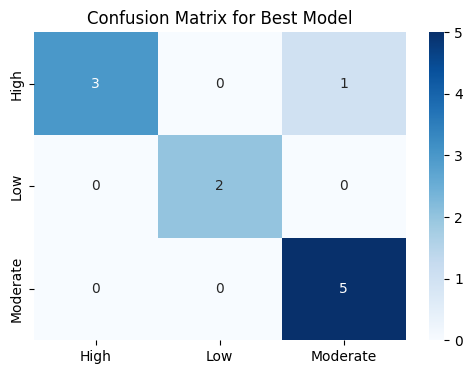

In [26]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_final, labels=final_clf.classes_)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d',
            xticklabels=final_clf.classes_, yticklabels=final_clf.classes_)
plt.title('Confusion Matrix for Best Model')
plt.show()

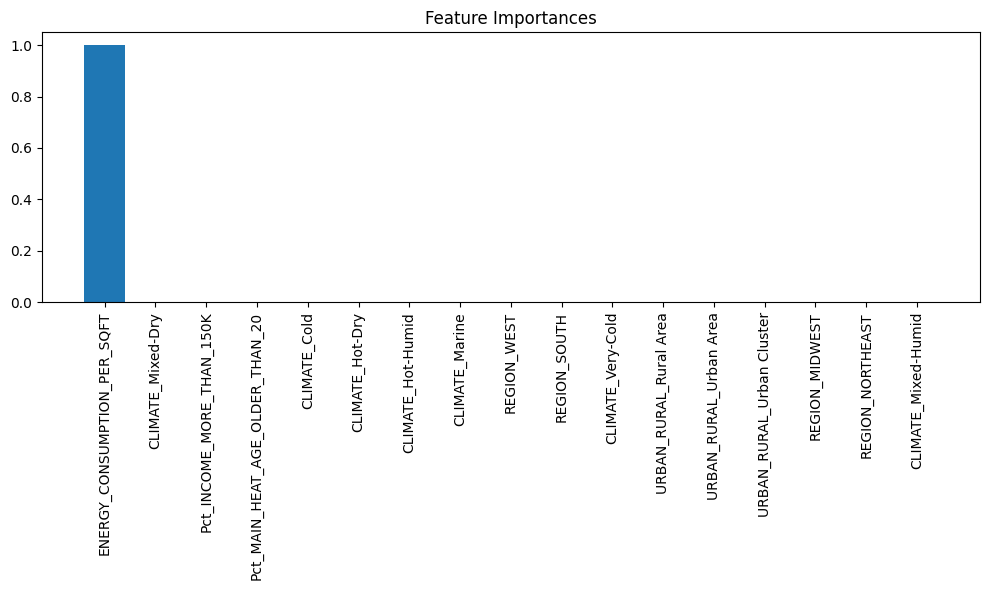

In [27]:
# Feature Importance Plot
importances = final_clf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), [X.columns[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

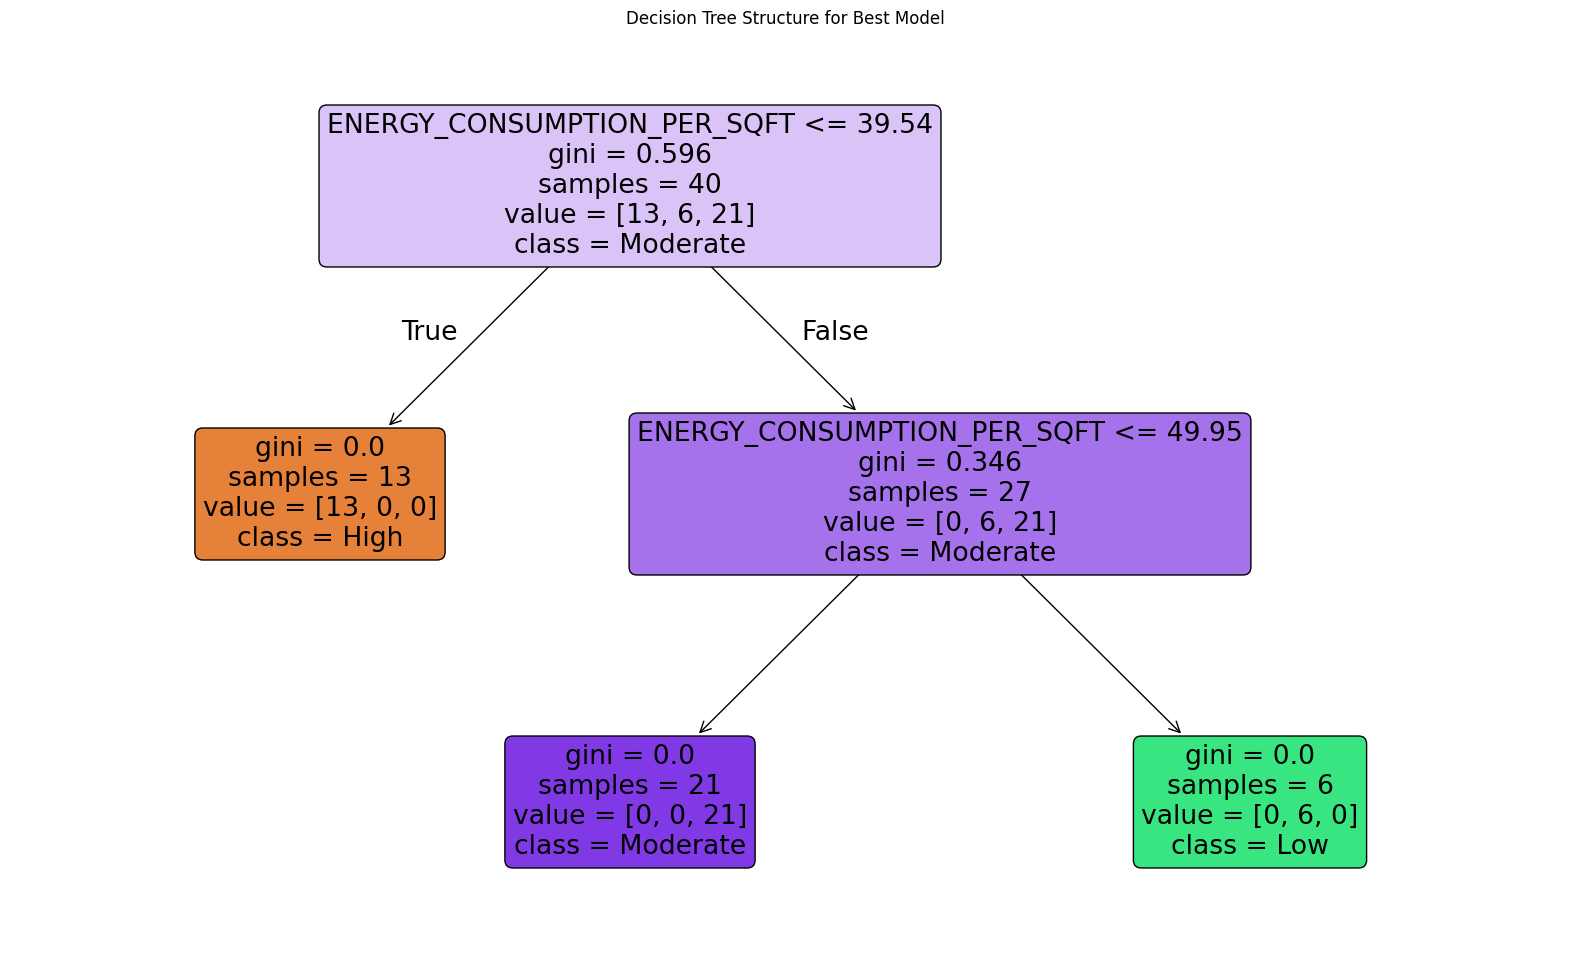

In [28]:
# Plot Decision Tree Structure
plt.figure(figsize=(20, 12))
plot_tree(final_clf, feature_names=X.columns, class_names=final_clf.classes_, filled=True, rounded=True)
plt.title('Decision Tree Structure for Best Model')
plt.show()

In [29]:
# Final 5-Fold Cross-Validation Scores
cv_scores = cross_val_score(final_clf, X, y, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", cv_scores)
print("Average CV Accuracy:", np.mean(cv_scores))

Cross-Validation Scores: [0.90909091 0.9        1.         0.9        1.        ]
Average CV Accuracy: 0.9418181818181818
